# 1. Contextualização
Este datasets contém informações simuladas relacionadas a defeitos de fabricação observados durante os processos de controle de qualidade. Inclui informações como tipo de defeito, data de detecção, localização dentro do produto, nível de gravidade, método de inspeção utilizado e custos de reparo. Este conjunto de dados pode ser usado para analisar padrões de defeitos, melhorar os processos de controle de qualidade e avaliar o impacto dos defeitos na qualidade do produto e nos custos de produção.

## 1.1. Metas e objetivos
A meta deste projeto é (1) através de uma exploração dos dados identificar tendências e tendências de defeitos, e (2) criar um modelo de Regressão capaz de prever os preços de reparo de defeitos. 

**Uma pequena observação**: Como o conjunto de dados é simulado, irei utilizar como moeda o Real Brasileiro. 

## 1.2. Estrutura do dataset
|Coluna|Descrição|
|---|---|
|defect_id|Identificador único do defeito|
|product_id|ID do produto associado com o defeito|
|defect_type|Categória do defeito (cósmetico, funcional ou estrutural)|
|defect_description|Descrição do defeito|
|defect_date|Data de quando o defeito ocorreu|
|defect_location|Local onde o defeito foi encontrado (superficie, componente)|
|severity|Severidade do defeito (pequena, moderada, crítica)|
|inspection_method|Método de inspeção (inspeção visual, teste automatizado)|
|repair_action|Ação tomada para o reparo|
|repair_cost|Custo do reparo|

# 2. Preparação do ambiente

## 2.1. Importação das bibliotecas e carregamento dos dados

In [168]:
# Manipulação dos dados
import pandas as pd
import numpy as np
import datetime as dt

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Machine Learning
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Paired')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [169]:
df = pd.read_csv("../data/raw/defects_data.csv")

## 2.2. Qualidade dos dados

In [170]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 1000 linhas e 8 colunas.


In [171]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 5 colunas categóricas.
O dataset possui: 3 colunas numéricas.


In [172]:
df.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


## 2.3. Limpeza e manipulação

In [174]:
# Vou realizar a conversão de defect_date para datetime

df.defect_date = pd.to_datetime(df.defect_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   defect_id          1000 non-null   int64         
 1   product_id         1000 non-null   int64         
 2   defect_type        1000 non-null   object        
 3   defect_date        1000 non-null   datetime64[ns]
 4   defect_location    1000 non-null   object        
 5   severity           1000 non-null   object        
 6   inspection_method  1000 non-null   object        
 7   repair_cost        1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 62.6+ KB


In [175]:
# Vou criar uma coluna com o mês do defeito para análises futuras

df['defect_month'] = df['defect_date'].dt.strftime('%Y-%m')
df.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost,defect_month
0,1,15,Structural,2024-06-06,Component,Minor,Visual Inspection,245.47,2024-06
1,2,6,Functional,2024-04-26,Component,Minor,Visual Inspection,26.87,2024-04
2,3,84,Structural,2024-02-15,Internal,Minor,Automated Testing,835.81,2024-02
3,4,10,Functional,2024-03-28,Internal,Critical,Automated Testing,444.47,2024-03
4,5,14,Cosmetic,2024-04-26,Component,Minor,Manual Testing,823.64,2024-04


# 3. Análise Exploratória de Dados

## 3.1. Estatísticas descritivas

In [176]:
df.repair_cost.describe().round(2)

count    1000.00
mean      507.63
std       289.62
min        10.22
25%       270.90
50%       506.43
75%       759.06
max       999.64
Name: repair_cost, dtype: float64

In [177]:
df.product_id.nunique()

100

- ``repair_cost`` é a única variável numérica neste conjunto de dados;
- A média é um pouco maior que a mediana mas a distribuição é próxima da normal;
- Existem 100 produtos únicos.

In [178]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
defect_type,1000,3,Structural,352
defect_location,1000,3,Surface,353
severity,1000,3,Minor,358
inspection_method,1000,3,Manual Testing,352
defect_month,1000,6,2024-01,191


- Os defeitos mais frequentes são estruturais, a localização mais comum é na superfície, e de menor severidade. 
- Janeiro foi o mês com maior ocorrência de defeitos

## 3.2. Aprofundando a análise

### Produtos

In [179]:
product_id = df.groupby("product_id").agg(defect_count = ('product_id', 'count'), total_repair_cost = ('repair_cost', 'sum')).sort_values(by = 'defect_count', ascending = False).reset_index()
product_id

,product_id,defect_count,total_repair_cost
0,63,20,9174.06
1,81,20,11740.64
2,97,19,8405.84
3,56,18,9916.30
4,4,16,6495.45
...,...,...,...
95,89,4,2471.16
96,52,4,1647.65
97,85,4,1337.25
98,19,4,1982.36


In [180]:
# Vou usar o top 10 para as visualizações

viz = product_id.sort_values(by = 'defect_count', ascending=False).head(10).copy()
viz

,product_id,defect_count,total_repair_cost
0,63,20,9174.06
1,81,20,11740.64
2,97,19,8405.84
3,56,18,9916.30
4,4,16,6495.45
5,10,16,10084.92
6,92,16,7588.84
7,6,15,8733.81
8,45,15,9532.36
9,74,15,8460.54


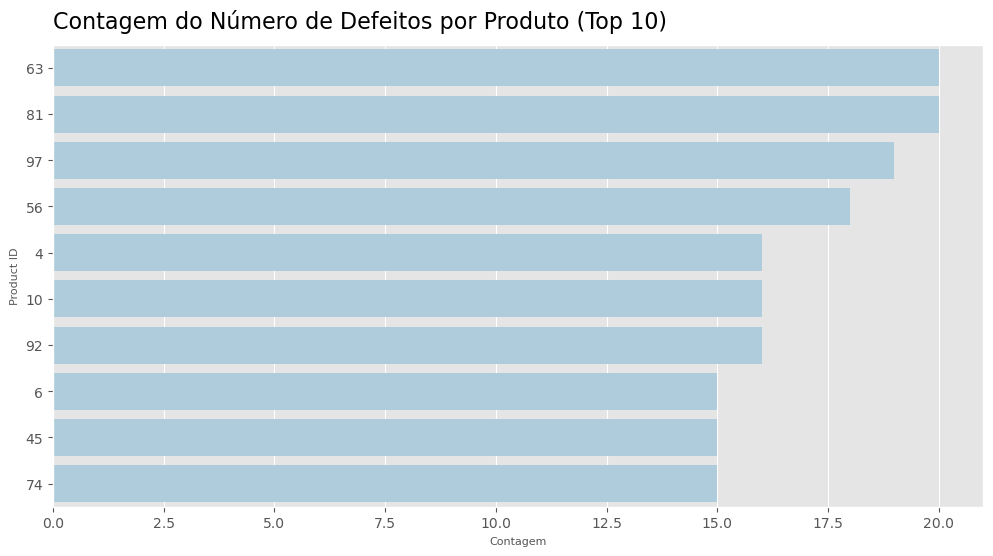

In [181]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(viz, x = 'defect_count', y = 'product_id', orient = 'h', ax = ax, order = viz['product_id'])
ax.set_title("Contagem do Número de Defeitos por Produto (Top 10)", loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel("Contagem", fontsize = 8)
ax.set_ylabel("Product ID", fontsize = 8)
plt.show()

In [182]:
print(f"Quantidade média de defeitos: {product_id['defect_count'].mean()}")
print(f"Desvio padrão da quantidade de defeitos: {product_id['defect_count'].std()}")
print(f"Mediana da quantidade de defeitos: {product_id['defect_count'].median()}")

Quantidade média de defeitos: 10.0
Desvio padrão da quantidade de defeitos: 3.60134654951408
Mediana da quantidade de defeitos: 10.0


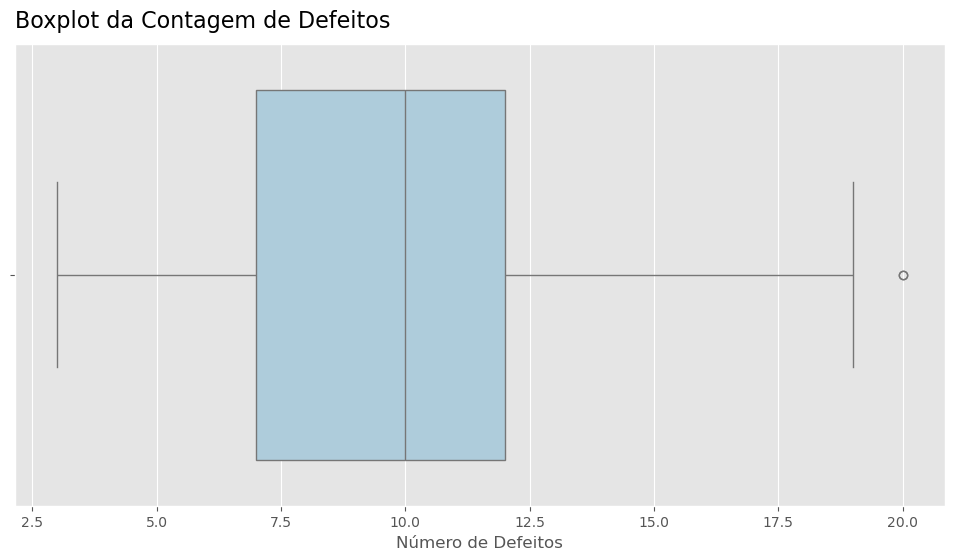

In [183]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(x = product_id['defect_count'], orient = 'h')
ax.set_title("Boxplot da Contagem de Defeitos", loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel("Número de Defeitos")
plt.show()

- Produtos com uma alta quantidade de defeitos como os 63 e 81 precisam ter seu processo produtivo investigado e melhorado com urgência, a frequência de defeitos pode ser considerada extrema;
- Estes produtos tem em média duas vezes mais defeitos que o padrão; 
- Os outros produtos no top 10 também necessitam uma investigação para melhora dos processos.

Vamos prosseguir para os custos

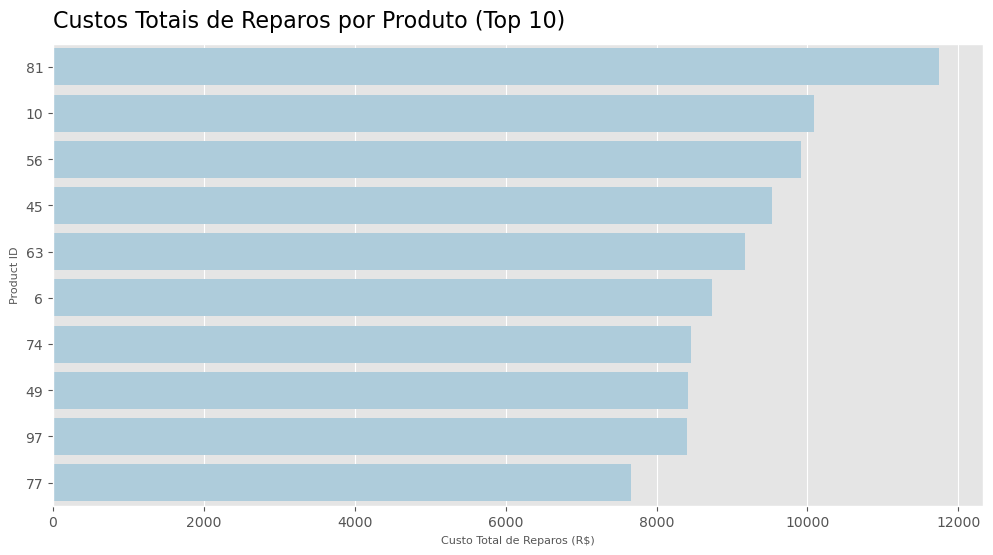

In [184]:
viz = product_id.sort_values(by = 'total_repair_cost', ascending=False).head(10).copy()


fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(viz, y = 'product_id', x = 'total_repair_cost', orient = 'h', ax = ax, order = viz.product_id)
ax.set_title("Custos Totais de Reparos por Produto (Top 10)", loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel("Custo Total de Reparos (R$)", fontsize = 8)
ax.set_ylabel("Product ID", fontsize = 8)
plt.show()

- Junto da alta quantidade de feitos o Produto 81 é aquele que mais causou prejuízos financeiros com reparos (custo médio de R$ 587,03 por reparo);
- Maioria dos produtos que estão nesta lista, estão no ranking de quantidade de defeitos.

### Defeitos por tipo, local e severidade

In [185]:
df.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost,defect_month
0,1,15,Structural,2024-06-06,Component,Minor,Visual Inspection,245.47,2024-06
1,2,6,Functional,2024-04-26,Component,Minor,Visual Inspection,26.87,2024-04
2,3,84,Structural,2024-02-15,Internal,Minor,Automated Testing,835.81,2024-02
3,4,10,Functional,2024-03-28,Internal,Critical,Automated Testing,444.47,2024-03
4,5,14,Cosmetic,2024-04-26,Component,Minor,Manual Testing,823.64,2024-04


In [186]:
def_type = df.groupby(['defect_type', 'defect_location', 'severity']).agg(defect_count = ('defect_id', 'count'), total_repair_cost = ('repair_cost', 'sum')).reset_index()
def_type

,defect_type,defect_location,severity,defect_count,total_repair_cost
0,Cosmetic,Component,Critical,34,17182.09
1,Cosmetic,Component,Minor,35,22658.33
2,Cosmetic,Component,Moderate,28,16576.50
3,Cosmetic,Internal,Critical,35,14568.13
4,Cosmetic,Internal,Minor,32,15787.32
...,...,...,...,...,...
22,Structural,Internal,Minor,44,25146.07
23,Structural,Internal,Moderate,30,12958.35
24,Structural,Surface,Critical,46,21754.09
25,Structural,Surface,Minor,51,25935.06


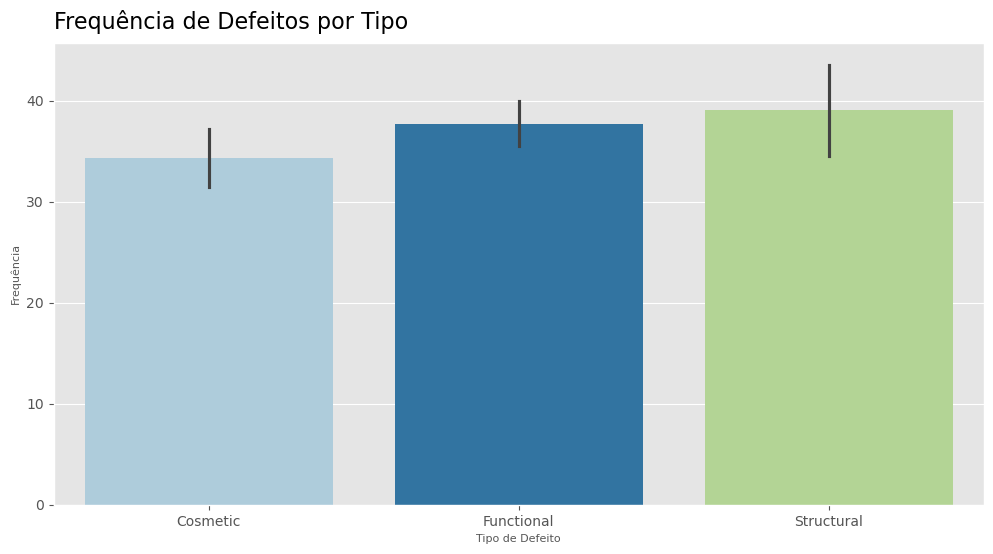

In [200]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(def_type, x = 'defect_type', y = 'defect_count', hue = 'defect_type')
ax.set_title("Frequência de Defeitos por Tipo", loc = 'left',fontsize = 16, pad = 10)
ax.set_xlabel("Tipo de Defeito", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

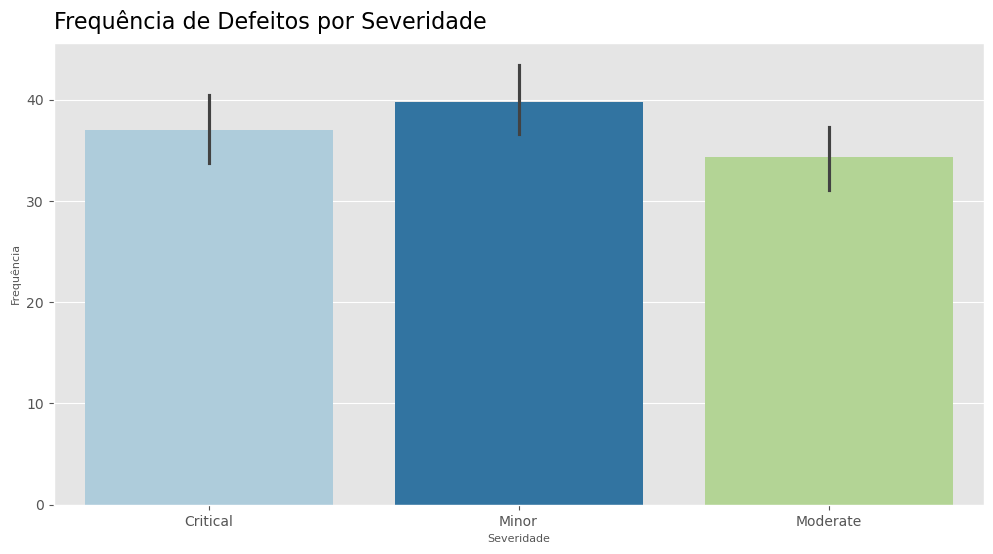

In [202]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(def_type, x = 'severity', y = 'defect_count', hue = 'severity')
ax.set_title("Frequência de Defeitos por Severidade", loc = 'left',fontsize = 16, pad = 10)
ax.set_xlabel("Severidade", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

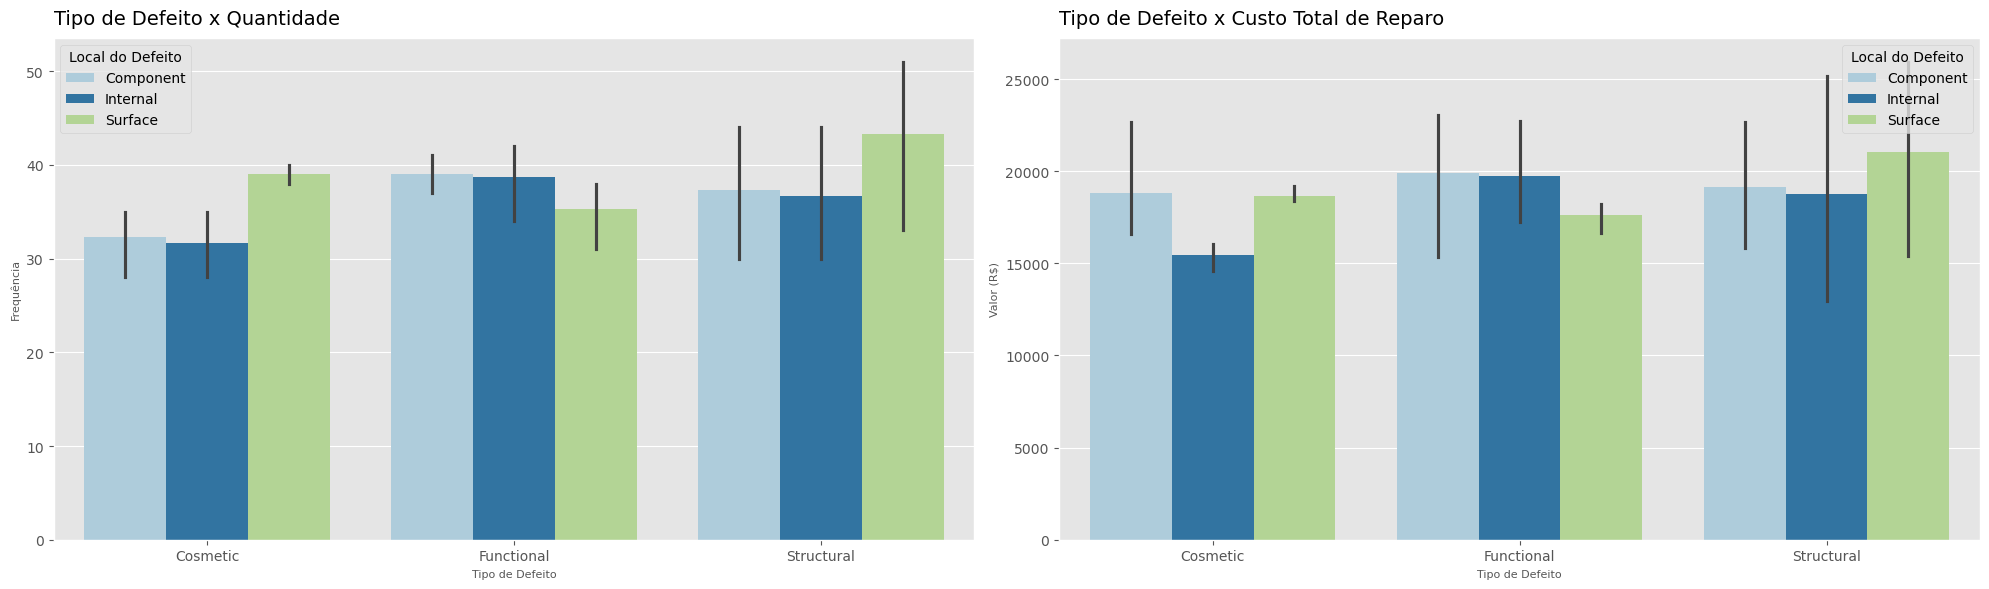

In [196]:
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.barplot(def_type, x = 'defect_type', y = 'defect_count', hue = 'defect_location', ax = axes[0])
axes[0].set_title("Tipo de Defeito x Quantidade", loc = 'left', fontsize = 14, pad = 10)
axes[0].set_xlabel("Tipo de Defeito", fontsize = 8)
axes[0].set_ylabel("Frequência", fontsize = 8)
axes[0].legend(title = 'Local do Defeito')

sns.barplot(def_type, x = 'defect_type', y = 'total_repair_cost', hue = 'defect_location', ax = axes[1])
axes[1].set_title("Tipo de Defeito x Custo Total de Reparo", loc = 'left', fontsize = 14, pad = 10)
axes[1].set_xlabel("Tipo de Defeito", fontsize = 8)
axes[1].set_ylabel("Valor (R$)", fontsize = 8)
axes[1].legend(title = 'Local do Defeito')

plt.tight_layout()
plt.show()

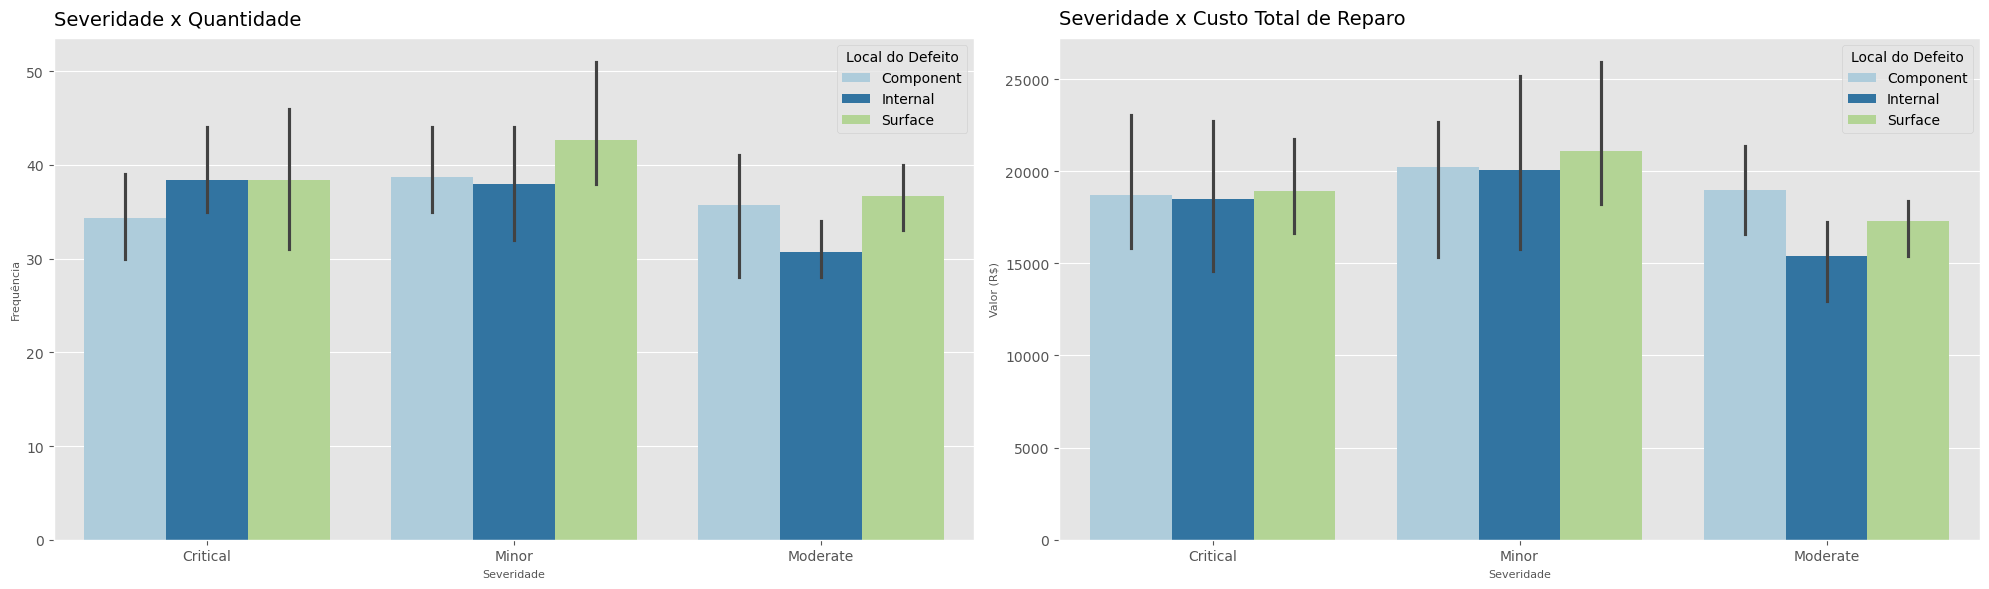

In [197]:
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.barplot(def_type, x = 'severity', y = 'defect_count', hue = 'defect_location', ax = axes[0])
axes[0].set_title("Severidade x Quantidade", loc = 'left', fontsize = 14, pad = 10)
axes[0].set_xlabel("Severidade", fontsize = 8)
axes[0].set_ylabel("Frequência", fontsize = 8)
axes[0].legend(title = 'Local do Defeito')

sns.barplot(def_type, x = 'severity', y = 'total_repair_cost', hue = 'defect_location', ax = axes[1])
axes[1].set_title("Severidade x Custo Total de Reparo", loc = 'left', fontsize = 14, pad = 10)
axes[1].set_xlabel("Severidade", fontsize = 8)
axes[1].set_ylabel("Valor (R$)", fontsize = 8)
axes[1].legend(title = 'Local do Defeito')

plt.tight_layout()
plt.show()